In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from astropy.io import fits
from jax_lensing.inversion import ks93inv, ks93
filename = '/gpfswork/rech/xdy/commun/nfw_samples/65_130_.5_3e14_1/0.148/samples_0.148_'
#filename = '/linkhome/rech/genpuc01/utb76xl/jax-lensing/scripts/results/cluster/detection/6e14/samples_0.148_6e14_'
#filename = '/linkhome/rech/genpuc01/utb76xl/jax-lensing/scripts/results/cluster/detection/9e14/samples_0.148_9e14_'
#filename = '/linkhome/rech/genpuc01/utb76xl/jax-lensing/scripts/results/cluster/detection/9e13/samples_0.148_9e13_'
#filename = '/Users/benjamin/Desktop/detection/detection/9e13/samples_0.148_9e13_'
#filename = '/Users/benjamin/Desktop/detection/detection/6e14/samples_0.148_6e14_'
#filename = '/Users/benjamin/Desktop/detection/detection/9e13/samples_0.148_9e13_'
#filename = '/Users/benjamin/Desktop/detection/0.148/samples_0.148_'

#filename = '/linkhome/rech/genpuc01/utb76xl/jax-lensing/scripts/results/cluster/65_130_.5_3e14_1/old/samples_0.07_'filename = '/linkhome/rech/genpuc01/utb76xl/jax-lensing/scripts/results/cluster/65_130_.5_3e14_1/old/samples_0.21_'
samples148 = fits.getdata(filename+'1.fits')

for i in range(2,21):
    if (i != 34) and (i != 36) and (i != 38) and (i != 39) :
        s = fits.getdata(filename+str(i)+'.fits')
        #samples01 = np.concatenate([samples01, s], axis=1)
        samples148 = np.concatenate([samples148, s], axis=1)

print(samples148.shape)

(3, 180, 129600)


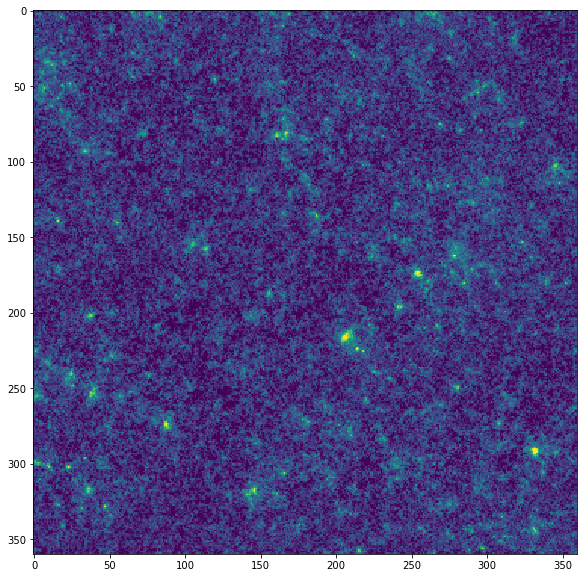

In [3]:
figure(figsize=(10,10))
imshow(samples148[2,10,...].reshape(360,360), vmin=-0.05, vmax=.3)

In [4]:
img = samples148[-1,...].reshape(-1,360,360)

In [5]:
x=65
y=130

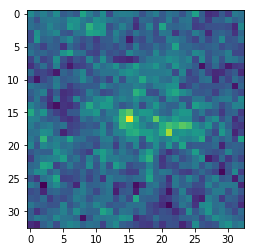

In [6]:
w = 16
ind = 4
imshow(img[ind,:][x-w:x+w+1, y-w:y+w+1])

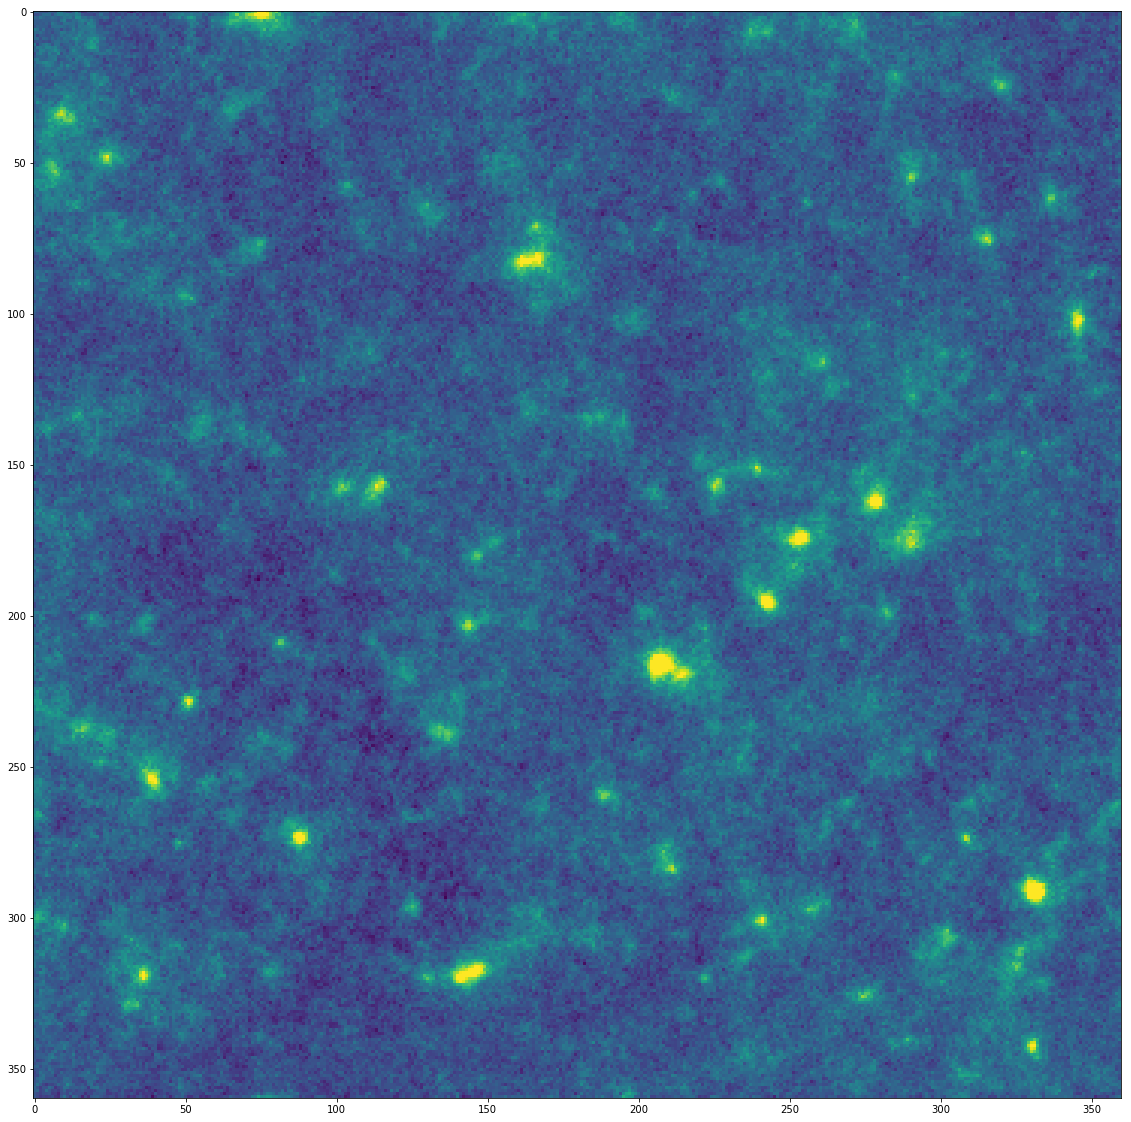

In [7]:
figure(figsize=[20,20])
imshow(img.mean(axis=0),vmax=0.15)

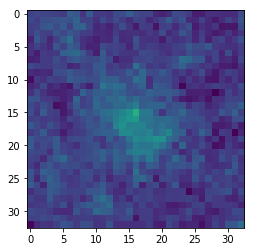

In [8]:
imshow(img[:,x-w:x+w+1, y-w:y+w+1].mean(axis=0),vmax=0.15)

In [9]:
#filename = '/gpfswork/rech/xdy/commun/nfw_samples/background/samples_no_cluster_0.148_'
#filename = '/linkhome/rech/genpuc01/utb76xl/jax-lensing/scripts/results/cluster/65_130_.5_3e14_1/old/background/samples_no_cluster_0.07_'
#filename = '/linkhome/rech/genpuc01/utb76xl/jax-lensing/scripts/results/cluster/65_130_.5_3e14_1/old/background/samples_no_cluster_0.21_'
filename = '/linkhome/rech/genpuc01/utb76xl/jax-lensing/scripts/results/cluster/detection/background/samples_0.148_6e14_'
#filename = '/Users/benjamin/Desktop/detection/detection/background/samples_0.148_6e14_'
samplesback = fits.getdata(filename+'1.fits')

for i in range(2,21):
    if (i != 34) and (i != 36) and (i != 38) and (i != 39) :
        s = fits.getdata(filename+str(i)+'.fits')
        #samples01 = np.concatenate([samples01, s], axis=1)
        samplesback = np.concatenate([samplesback, s], axis=1)

print(samplesback.shape)

(3, 180, 129600)


In [10]:
img_background = samplesback[-1,...].reshape(-1,360,360)

Text(0.5,1,'mean cluster')

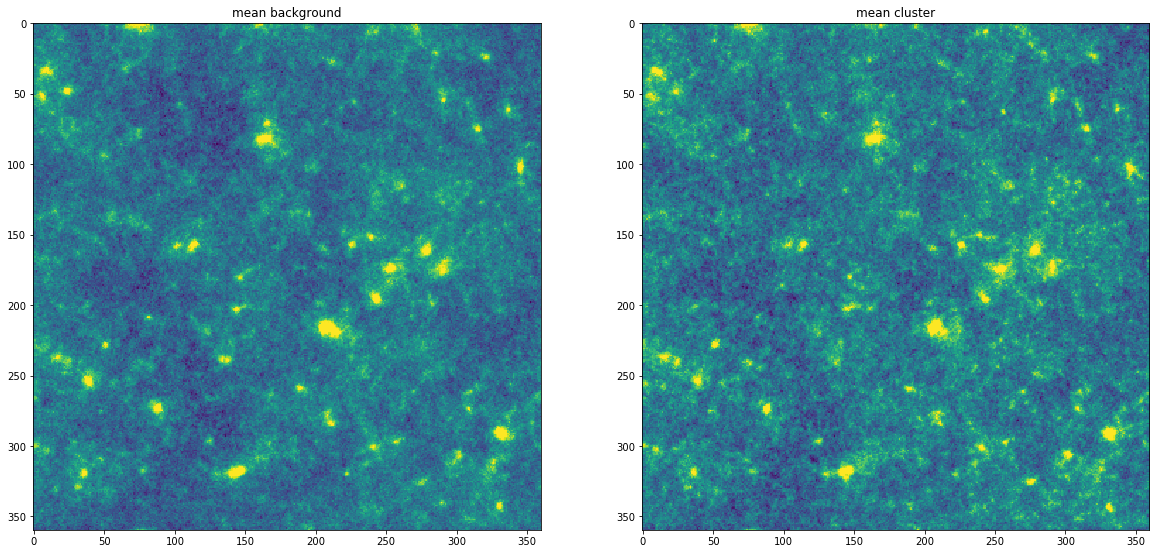

In [11]:
figure(figsize=[20,10])
subplot(121)
imshow(img_background.mean(axis=0),vmax=0.1)
title('mean background')
subplot(122)
imshow(img[:27].mean(axis=0),vmax=0.1)
title('mean cluster')

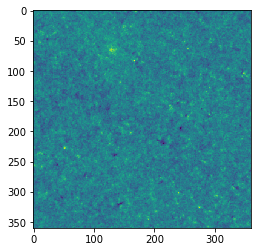

In [12]:
imshow(img[:27].mean(axis=0) - img_background.mean(axis=0))

Text(0.5,1,'mean background')

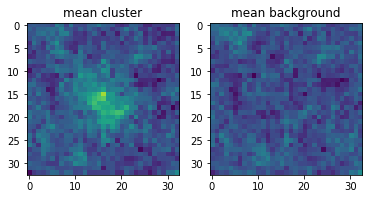

In [13]:
subplot(121)
imshow(img[:,x-w:x+w+1, y-w:y+w+1].mean(axis=0),vmax=0.1)
title('mean cluster')
subplot(122)
imshow(img_background[:,x-w:x+w+1, y-w:y+w+1].mean(axis=0),vmax=0.1)
title('mean background')

In [14]:
import lenspack

In [15]:
radius = linspace(0,16,16)

In [16]:
lenspack.image.filters.aperture_mass?

In [116]:
def detection_filter(img, ke, filter_name='jbj04'):
    
    radius = linspace(0,16,16)
    res = [lenspack.image.filters.aperture_mass(img[:,x-w:x+w+1, y-w:y+w+1].mean(axis=0), i, filter=filter_name)
           for i in radius]
    res = np.stack(res,axis=0)
    
    resb = [lenspack.image.filters.aperture_mass(img_background[:,x-w:x+w+1, y-w:y+w+1].mean(axis=0), i, 
                                                 filter=filter_name) 
            for i in radius]
    
    resb = np.stack(resb,axis=0)

    std = resb.reshape([16,-1]).std(axis=1)[12]
    rad = radius[12]

    filtered_img = [lenspack.image.filters.aperture_mass(img[i,x-w:x+w+1, y-w:y+w+1],
                                                         rad,
                                                         filter=filter_name)
                    for i in range(len(img))]

    filtered_img = np.stack(filtered_img,axis=0)
    
    det = filtered_img[:, 16,16]/std > 5.
    non_det = filtered_img[:, 16,16]/std < 5.
    
    # compute SNR
    filtered_cluster = lenspack.image.filters.aperture_mass(ke[x-w:x+w+1, y-w:y+w+1], rad, filter=filter_name)
    snr = filtered_cluster[16,16]/0.148
    
    return snr, where(det)[0].shape[0]/len(det), filtered_img

In [117]:
# filter : {'s98', 'vw98', 'jbj04', 'starlet'}
filter='starlet'

In [118]:
res = [lenspack.image.filters.aperture_mass(img[:,x-w:x+w+1, y-w:y+w+1].mean(axis=0), i, filter=filter ) for i in radius]
res = np.stack(res,axis=0)

In [119]:
resb = [lenspack.image.filters.aperture_mass(img_background[:,x-w:x+w+1, y-w:y+w+1].mean(axis=0), i, filter=filter) for i in radius]
resb = np.stack(resb,axis=0)

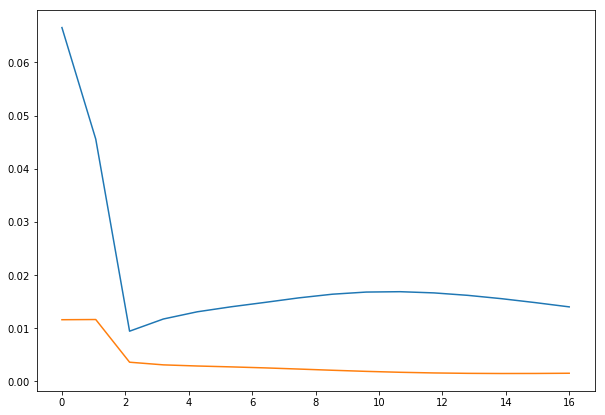

In [120]:
plot(radius, res[:,16,16])
plot(radius, resb.reshape([16,-1]).std(axis=1))

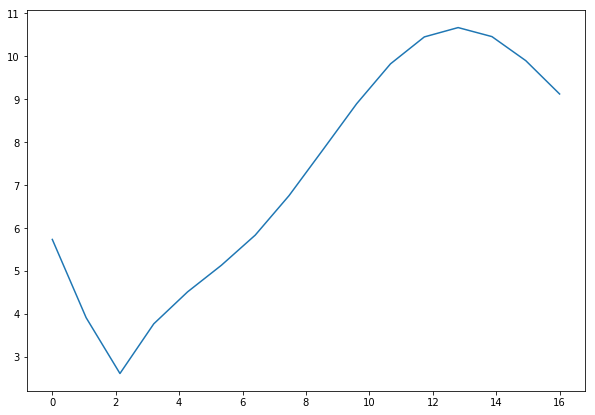

In [121]:
plot(radius, res[:,16,16]/resb.reshape([16,-1]).std(axis=1))

In [122]:
std = resb.reshape([16,-1]).std(axis=1)[12]
rad = radius[12]
rad, std

(12.8, 0.001517747227274006)

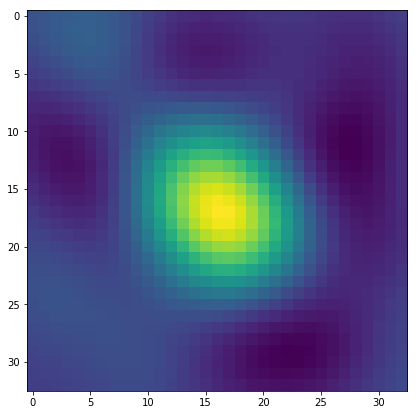

In [123]:
imshow(lenspack.image.filters.aperture_mass(img[:,x-w:x+w+1, y-w:y+w+1].mean(axis=0), rad, filter=filter))

In [124]:
filtered_img = [lenspack.image.filters.aperture_mass(img[i,x-w:x+w+1, y-w:y+w+1], rad, filter=filter) for i in range(len(img))]

In [125]:
filtered_back = [lenspack.image.filters.aperture_mass(img_background[i,x-w:x+w+1, y-w:y+w+1], rad, filter=filter) for i in range(len(img_background))]

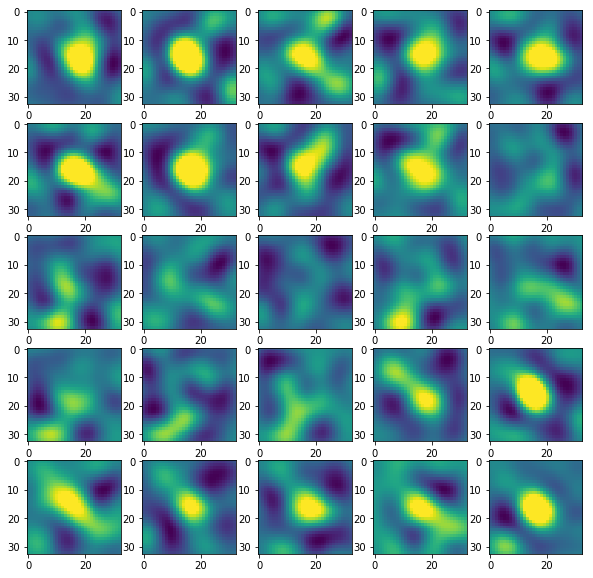

In [126]:
figure(figsize=[10,10])
try:
  for i in range(25):
    subplot(5,5,i+1)
    imshow(filtered_img[i]/std,vmax=10)
except ValueError:
  pass

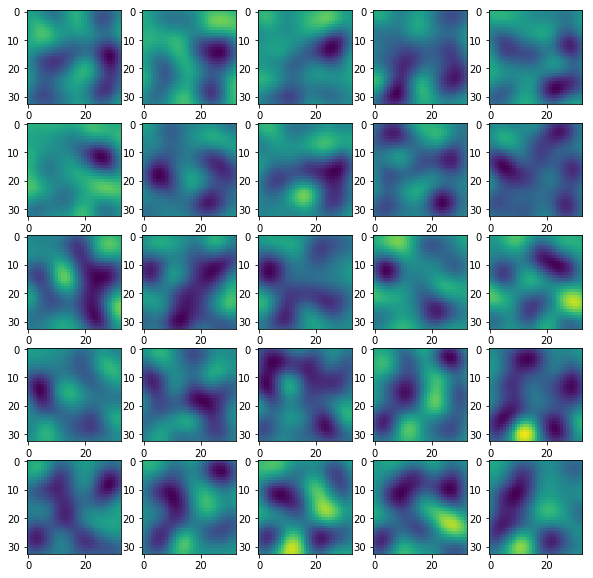

In [127]:
figure(figsize=[10,10])
try:
  for i in range(25):
    subplot(5,5,i+1)
    imshow(filtered_back[i]/std,vmax=10)
except IndexError:
  pass

In [128]:
filtered_img = np.stack(filtered_img,axis=0)

In [129]:
filtered_back = np.stack(filtered_back,axis=0)

In [130]:
filtered_img.shape, filtered_back.shape

((180, 33, 33), (180, 33, 33))

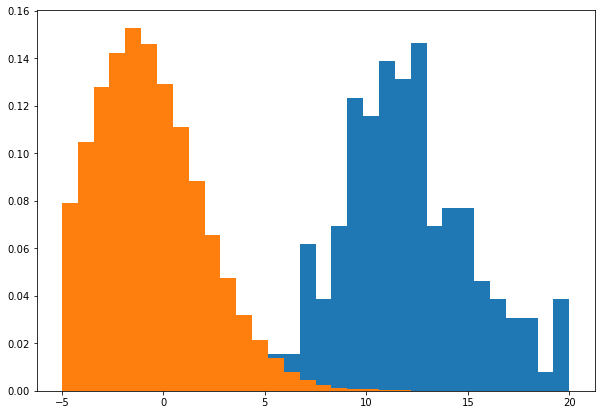

In [131]:
hist(filtered_img.reshape([filtered_img.shape[0], -1]).max(axis=1)/std, 32, range=[-5,20],density=True);
hist(filtered_back.flatten()/std, 32, range=[-5,20],density=True);

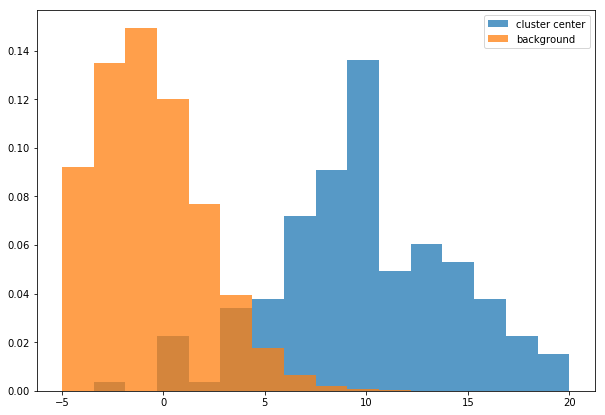

In [132]:
hist(filtered_img[:, 16,16]/std, 16, range=[-5,20],density=True,alpha=0.75,label='cluster center');
hist(filtered_back.flatten()/std, 16, range=[-5,20],density=True,alpha=0.75,label='background');
legend()

In [133]:
# ok, so let's pick a detection threshold around 5 sigma

In [134]:
det = filtered_img[:, 16,16]/std > 4.
non_det = filtered_img[:, 16,16]/std < 4.

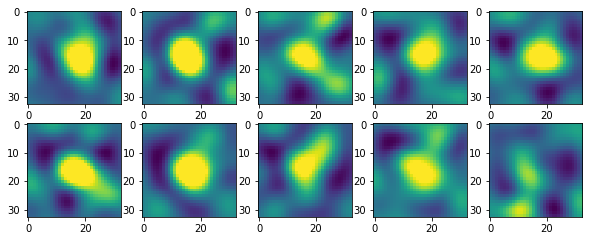

In [135]:
figure(figsize=[10,10])
try:
  for i in range(10):
    subplot(5,5,i+1)
    imshow(filtered_img[det][i]/std,vmax=10)
    savefig('detection_yes_3e14.png')
except IndexError:
  pass

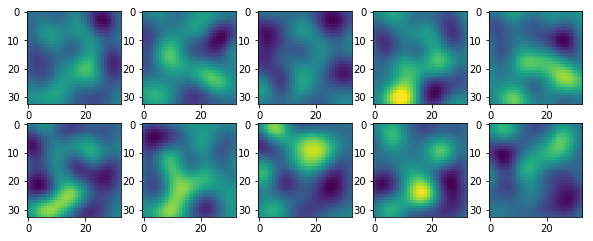

In [136]:
figure(figsize=[10,10])
try:
  for i in range(10):
    subplot(5,5,i+1)
    imshow(filtered_img[non_det][i]/std,vmax=10)
    savefig('detection_no_3e14.png')
except IndexError:
  pass

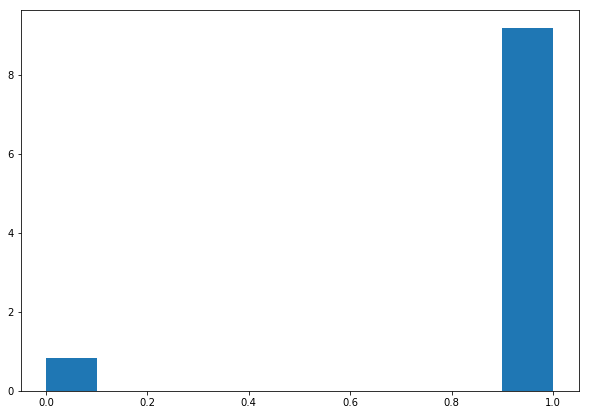

In [137]:
hist(det*1., density=True);

In [138]:
where(det)[0].shape[0]/len(det)

0.9166666666666666

In [139]:
from lenspack.halo.profiles import nfw_profile
from astropy import units as u
from lenspack.image.inversion import ks93, ks93inv

In [140]:
def gen_nfw_shear(x_cen, y_cen, resolution, nx, ny, z, m, zs=None, redshift_distribution=None, como=None):
    """
    returns: a map g1,g2 of size [nx,ny]
    """

    halo = nfw_profile(z=z, c200=1, m200=m, r200=None, cosmology='default')

    resolution = resolution*u.arcmin #arcmin/pixel
    cosmo = halo.cosmo
    d_A = cosmo.angular_diameter_distance(z=z_halo)
    distance_Mpc = (resolution * d_A).to(u.Mpc, u.dimensionless_angles()) # Mpc/pixel

    dist_from_halo = np.zeros((nx, ny)) 
    phi_halo = np.zeros((nx, ny))

    for i in range(ny):
        for j in range(nx):
            dist_from_halo[i,j] = np.sqrt((i-x)**2 + (j-y)**2)
            #phi_halo[i,j] =  np.arccos((j-y) / dist_from_halo[i,j])

    for i in range(ny):
        for j in range(nx):
            if i-x > 0:
                phi_halo[i,j] =  np.arccos((j-y) / dist_from_halo[i,j])
            else:
                phi_halo[i,j] = 2*np.pi - np.arccos((j-y) / dist_from_halo[i,j])

    dist_from_halo = dist_from_halo * distance_Mpc
    phi_halo[x, y] = 0.
    
    gamma_t = halo.gamma_t(r=dist_from_halo, zs=zs)

    gamma_1 = - gamma_t * np.cos(2*phi_halo)
    gamma_2 = - gamma_t * np.sin(2*phi_halo)
    
    return gamma_1, gamma_2

/gpfslocalsup/pub/anaconda-py3/2020.02/envs/tensorflow-gpu-2.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars


0.0847315854247063


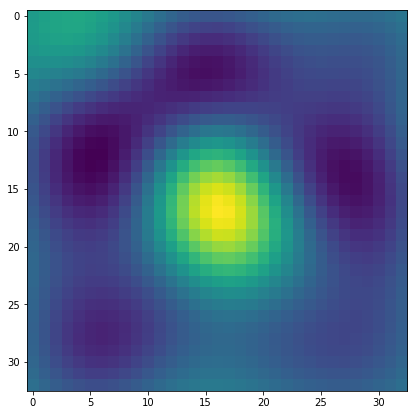

In [141]:
convergence = fits.getdata('../data/ktng/ktng_cosmos_kappa360.fits').astype('float32')
meas_shear = np.stack(ks93inv(convergence, np.zeros_like(convergence)), axis=-1)

resolution = 0.29 #arcmin/pixel
z_halo = 0.5
mass_halo = 9e13
zs = 1

nx = 360# map width pixel
ny = 360 # map height pixel
x = 65 # cluster x coord pixel
y = 130 # cluster y coord pixel

g1, g2 = gen_nfw_shear(x_cen=x, y_cen=y, resolution=resolution, nx=nx, ny=ny, z=z_halo, m=mass_halo, zs=zs)
ke_cluster, kb_cluster = ks93(meas_shear[...,0] + g1, meas_shear[...,1] + g2)

w = 16

vmin = -0.05
vmax = 0.3
imshow(ke_cluster[x-w:x+w+1, y-w:y+w+1], vmin=vmin, vmax=vmax)

filtered_cluster = lenspack.image.filters.aperture_mass(ke_cluster[x-w:x+w+1, y-w:y+w+1], rad, filter=filter)
print(filtered_cluster[16,16]/0.148)
imshow(filtered_cluster)

In [142]:
detection_filter(img, ke_cluster, filter_name='starlet')

(0.0847315854247063,
 0.8944444444444445,
 array([[[ 1.18649556e-03,  1.54648143e-03,  1.77990181e-03, ...,
          -4.85935926e-03, -3.86626923e-03, -2.82633230e-03],
         [ 1.22094731e-03,  1.63483835e-03,  1.92760630e-03, ...,
          -6.01336649e-03, -4.87170828e-03, -3.64776740e-03],
         [ 1.09884279e-03,  1.53994721e-03,  1.86887526e-03, ...,
          -6.95907805e-03, -5.71168590e-03, -4.34212067e-03],
         ...,
         [-1.48775828e-03, -1.89518285e-03, -2.26181885e-03, ...,
           6.51948173e-04,  1.60972144e-03,  2.31132605e-03],
         [-1.12932775e-03, -1.48829772e-03, -1.82001093e-03, ...,
           7.40241120e-04,  1.68461001e-03,  2.35177261e-03],
         [-7.32416023e-04, -1.03800949e-03, -1.32969949e-03, ...,
           6.93928140e-04,  1.58095262e-03,  2.19831319e-03]],
 
        [[ 6.87383141e-04,  5.73707580e-04,  3.50182539e-04, ...,
           2.81546619e-03,  2.14183163e-03,  1.52533351e-03],
         [ 6.34630085e-04,  4.49962540e-04,  

In [143]:
# With this setting, we detect the cluster at 5 sigma confidence : 
# 9e13 : around 5.6% of the time, SNR = 1869
# 3e14 : around 77% of the time,  SNR = 4359
# 6e14 : around 96% of the time,  SNR = 6931
# 9e14 : around 100% of the time, SNR = 9013

Text(0,0.5,'% of detection')

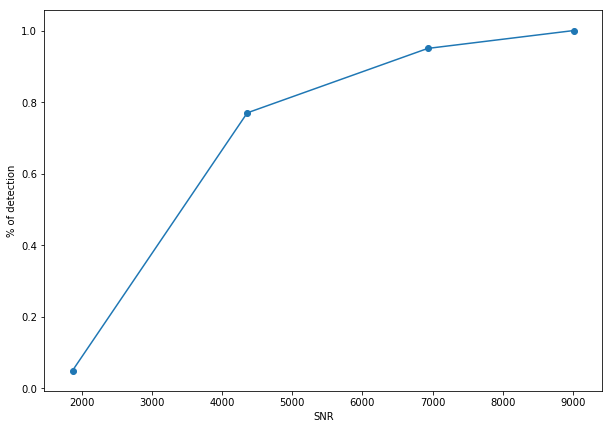

In [144]:
snrs = [1869, 4359, 6931, 9013]
detections = [0.05, 0.77, 0.95, 1.]

plot(snrs, detections)
scatter(snrs, detections)
xlabel('SNR')
ylabel('% of detection')

In [95]:
#filename = '/Users/benjamin/Desktop/detection/detection/9e13/samples_0.148_9e13_'
filename = '/linkhome/rech/genpuc01/utb76xl/jax-lensing/scripts/results/cluster/detection/9e13/samples_0.148_9e13_'
samples913 = fits.getdata(filename+'1.fits')
for i in range(2,21):
    if (i != 34) and (i != 36) and (i != 38) and (i != 39) :
        s = fits.getdata(filename+str(i)+'.fits')
        #samples01 = np.concatenate([samples01, s], axis=1)
        samples913 = np.concatenate([samples913, s], axis=1)
g1, g2 = gen_nfw_shear(x_cen=x, y_cen=y, resolution=resolution, nx=nx, ny=ny, z=z_halo, m=9e13, zs=zs)
ke913, _ = ks93(meas_shear[...,0] + g1, meas_shear[...,1] + g2)

"""
filename = '/linkhome/rech/genpuc01/utb76xl/jax-lensing/scripts/results/cluster/detection/15e14/samples_0.148_15e14_'
samples1514 = fits.getdata(filename+'1.fits')
for i in range(2,21):
    if (i != 34) and (i != 36) and (i != 38) and (i != 39) :
        s = fits.getdata(filename+str(i)+'.fits')
        #samples01 = np.concatenate([samples01, s], axis=1)
        samples1514 = np.concatenate([samples1514, s], axis=1)
g1, g2 = gen_nfw_shear(x_cen=x, y_cen=y, resolution=resolution, nx=nx, ny=ny, z=z_halo, m=1.5e14, zs=zs)
ke1514, _ = ks93(meas_shear[...,0] + g1, meas_shear[...,1] + g2)
"""

#filename = '/Users/benjamin/Desktop/detection/0.148/samples_0.148_'
filename = '/linkhome/rech/genpuc01/utb76xl/jax-lensing/scripts/results/cluster/65_130_.5_3e14_1/0.148/samples_0.148_'
samples314 = fits.getdata(filename+'1.fits')
for i in range(2,21):
    if (i != 34) and (i != 36) and (i != 38) and (i != 39) :
        s = fits.getdata(filename+str(i)+'.fits')
        #samples01 = np.concatenate([samples01, s], axis=1)
        samples314 = np.concatenate([samples314, s], axis=1)
g1, g2 = gen_nfw_shear(x_cen=x, y_cen=y, resolution=resolution, nx=nx, ny=ny, z=z_halo, m=3e14, zs=zs)
ke314, _ = ks93(meas_shear[...,0] + g1, meas_shear[...,1] + g2)

#filename = '/Users/benjamin/Desktop/detection/detection/6e14/samples_0.148_6e14_'
filename = '/linkhome/rech/genpuc01/utb76xl/jax-lensing/scripts/results/cluster/detection/6e14/samples_0.148_6e14_'
samples614 = fits.getdata(filename+'1.fits')
for i in range(2,21):
    if (i != 34) and (i != 36) and (i != 38) and (i != 39) :
        s = fits.getdata(filename+str(i)+'.fits')
        #samples01 = np.concatenate([samples01, s], axis=1)
        samples614 = np.concatenate([samples614, s], axis=1)
g1, g2 = gen_nfw_shear(x_cen=x, y_cen=y, resolution=resolution, nx=nx, ny=ny, z=z_halo, m=6e14, zs=zs)
ke614, _ = ks93(meas_shear[...,0] + g1, meas_shear[...,1] + g2)

#filename = '/Users/benjamin/Desktop/detection/detection/9e14/samples_0.148_9e14_'
filename = '/linkhome/rech/genpuc01/utb76xl/jax-lensing/scripts/results/cluster/detection/9e14/samples_0.148_9e14_'
samples914 = fits.getdata(filename+'1.fits')
for i in range(2,21):
    if (i != 34) and (i != 36) and (i != 38) and (i != 39) :
        s = fits.getdata(filename+str(i)+'.fits')
        #samples01 = np.concatenate([samples01, s], axis=1)
        samples914 = np.concatenate([samples914, s], axis=1)
g1, g2 = gen_nfw_shear(x_cen=x, y_cen=y, resolution=resolution, nx=nx, ny=ny, z=z_halo, m=9e14, zs=zs)
ke914, _ = ks93(meas_shear[...,0] + g1, meas_shear[...,1] + g2)

/gpfslocalsup/pub/anaconda-py3/2020.02/envs/tensorflow-gpu-2.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars


In [145]:
filter_name = 'starlet'
#filter_name = 'jbj04'
# {'s98', 'vw98', 'jbj04', 'starlet'}

In [146]:
det913_starlet = detection_filter(samples913[-1,...].reshape(-1,360,360), ke913, filter_name='starlet')
#det913_jbj04 = detection_filter(samples913[-1,...].reshape(-1,360,360), ke913, filter_name='jbj04')

In [147]:
#det15e14_starlet = detection_filter(samples1514[-1,...].reshape(-1,360,360), ke1514, filter_name='starlet')
#det15e14_jbj04 = detection_filter(samples1514[-1,...].reshape(-1,360,360), ke1514, filter_name='jbj04')

In [148]:
det314_starlet = detection_filter(samples314[-1,...].reshape(-1,360,360), ke314, filter_name='starlet')
#det314_jbj04 = detection_filter(samples314[-1,...].reshape(-1,360,360), ke314, filter_name='jbj04')

In [149]:
det614_starlet = detection_filter(samples614[-1,...].reshape(-1,360,360), ke614, filter_name='starlet')
#det614_jbj04 = detection_filter(samples614[-1,...].reshape(-1,360,360), ke614, filter_name='jbj04')

In [150]:
det914_starlet = detection_filter(samples914[-1,...].reshape(-1,360,360), ke914, filter_name='starlet')
#det914_jbj04 = detection_filter(samples914[-1,...].reshape(-1,360,360), ke914, filter_name='jbj04')

In [151]:
snr_starlet = [det913_starlet[0], det314_starlet[0], det614_starlet[0], det914_starlet[0]]
ratio_starlet = [det913_starlet[1], det314_starlet[1], det614_starlet[1], det914_starlet[1]]

#snr_jbj04 = [det913_jbj04[0], det314_jbj04[0], det614_jbj04[0], det914_jbj04[0]]
#ratio_jbj04 = [det913_jbj04[1], det314_jbj04[1], det614_jbj04[1], det914_jbj04[1]]

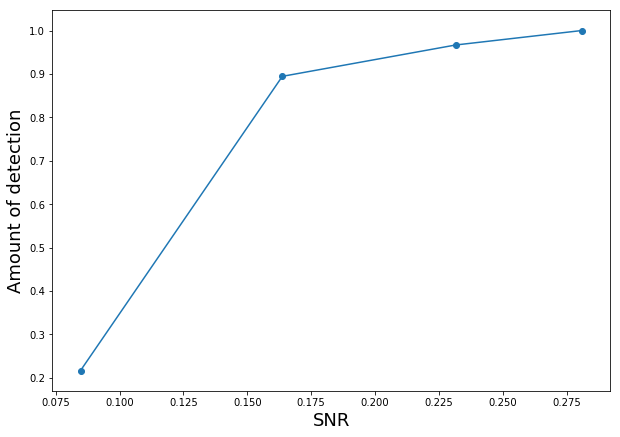

In [152]:
plot(snr_starlet, ratio_starlet, label='starlet')
#plot(snr_jbj04, ratio_jbj04, label='jbj04')
scatter(snr_starlet, ratio_starlet)
xlabel('SNR', fontsize=18)
ylabel('Amount of detection', fontsize=18)
savefig('SNR.png')
#legend()

In [215]:
kwargs = dict(histtype='stepfilled', linewidth=1., fc="None", density=True, bins=16, zorder=1)
range = dict(range=[-10,35])

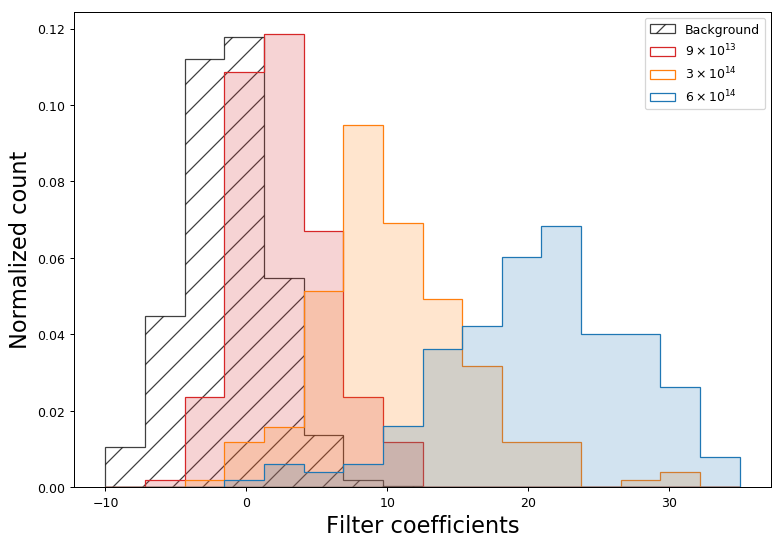

In [218]:
figure(figsize(10,7), dpi=90)

plt.rcParams.update({'hatch.color': 'k'})

hist(filtered_back.flatten()/std, hatch='/', label='Background', alpha=.75, ec='k', color='white', histtype='stepfilled', density=True, bins=16, zorder=0,**range);
hist(det913_starlet[2][:, 16,16]/std,label=r'$9\times10^{13}~M_\odot$', ec='tab:red', alpha=1, **kwargs, **range);
hist(det913_starlet[2][:, 16,16]/std, color='tab:red', alpha=.2, density=True, bins=16, **range);
hist(det314_starlet[2][:, 16,16]/std,label=r'$3\times10^{14}~M_\odot$', ec='tab:orange',  alpha=1, **kwargs, **range);
hist(det314_starlet[2][:, 16,16]/std, color='tab:orange', alpha=.2, density=True, bins=16, **range);
hist(det614_starlet[2][:, 16,16]/std,label=r'$6\times10^{14}~M_\odot$', ec='tab:blue', alpha=1, **kwargs, **range);
hist(det614_starlet[2][:, 16,16]/std, color='tab:blue', alpha=.2, density=True, bins=16, **range);

#hist(det914_starlet[2][:, 16,16]/std,label=r'$9\times10^{14}~M_\odot$', ec='pink', alpha=1, **kwargs);
xlabel('Filter coefficients', fontsize=18)
ylabel('Normalized count', fontsize=18)
legend()

savefig('hist_detection.png')

In [189]:
det913_starlet[0]/std

55.827204887661644

In [156]:
det314_starlet[0]/std

107.85117433452781

In [115]:
det913_starlet[0]*std

0.00012860112884087858